## <font style="font-family:roboto;color:#455e6c"> Ontologies and workflows in computational materials science</font>  

<div class="admonition note" name="html-admonition" style="background:#e3f2fd; padding: 10px">
<font style="font-family:roboto;color:#455e6c"> IUC17: Ontologies for defects in crystals </font> </br>
</div>

<table table style='table-layout:fixed;width:100%' border="0">
  <th style='width: 33%;'> </th>
<tr>
  <td>
    <img src="images/ocdo_logo.png" width="50%" align="center">
  </td>
  <td>
    <img src="images/logo.png" width="50%" align="center">
  </td>
  <td>
    <img src="images/Logo_NFDI-MatWerk.png" width="50%" align="center">
  </td>
</tr>
</table>

### <font style="font-family:roboto;color:#455e6c"> Obtaining new materials properties from existing data </font>

Explore the DC3 dataset to extract physical quantities which were not explicitely calculated. The dataset was used for training ML model for structural recognition. We have made the annotated set which includes information not just about the structure, but also about the simulation method (MD), including temperature, potential.

Start with imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pychromatic import Multiplot
import matplotlib
from atomrdf import System, KnowledgeGraph

Unarchive the dataset. Can be done with either a tar archive or simply a folder.

In [2]:
#kg = KnowledgeGraph.unarchive('DC3_dataset_00.tar.gz')
kg = KnowledgeGraph.unarchive('DC3_dataset_00', compress=False)

In [3]:
kg.n_samples

2339

There are more than 2000 MD snapshots in this dataset. 

Create a function to find for all elements in the dataset

The first few lines of the function queries the knowledge graph to extract the necessary values.

```
condition = (kg.terms.cmso.hasChemicalSymbol==element) & (kg.terms.cmso.hasElementRatio==1.0) & (kg.terms.rdfs.label@kg.terms.asmo.InputParameter=='temperature') & (kg.terms.rdfs.label@kg.terms.cmso.CalculatedProperty=='Volume')
```
This is the condition for the automated SPARQL query. Here, only pure structures of the given element is selected, and the associated temperature and volume is selected.

```
q = kg.auto_query(kg.terms.cmso.AtomicScaleSample, 
                  [condition,
                   kg.terms.cmso.hasReference@kg.terms.asmo.hasInteratomicPotential, 
                   kg.terms.asmo.hasValue@kg.terms.asmo.InputParameter,
                  kg.terms.asmo.hasValue@kg.terms.cmso.CalculatedProperty,])
```

This condition is then used to perform the query, and get data including the interatomic potential. This ensures that only calculations done with the same interatomic potential is used for calculating the thermal expansion coefficient.

In [58]:
def calculate_alpha(element, kg, res_dict, anchor_temp=293):
    condition = (kg.terms.cmso.hasChemicalSymbol==element) & (kg.terms.cmso.hasElementRatio==1.0) & (kg.terms.rdfs.label@kg.terms.asmo.InputParameter=='temperature') & (kg.terms.rdfs.label@kg.terms.cmso.CalculatedProperty=='Volume')
    q = kg.auto_query(kg.terms.cmso.AtomicScaleSample, 
                  [condition,
                   kg.terms.cmso.hasReference@kg.terms.asmo.hasInteratomicPotential, 
                   kg.terms.asmo.hasValue@kg.terms.asmo.InputParameter,
                  kg.terms.asmo.hasValue@kg.terms.cmso.CalculatedProperty,])
    q = q.sort_values('InputParameter_hasValuevalue')
    temps = np.array([x.toPython() for x in q.InputParameter_hasValuevalue.values])
    volumes = np.array([x.toPython() for x in q.CalculatedProperty_hasValuevalue.values])
    temps, indices = np.unique(temps, return_index=True)
    volumes = volumes[indices]
    anchor_arg = np.argsort(np.abs(temps-anchor_temp))[0]
    mind = anchor_arg-3
    maxd = anchor_arg+3
    fit = np.polyfit(temps[mind:maxd], volumes[mind:maxd], 1)
    alpha = (1/volumes[mind])*fit[0]
    res_dict[element] = {}
    res_dict[element]['temp'] = temps
    res_dict[element]['vol'] = volumes
    res_dict[element]['alpha'] = alpha

Finally, values around the given temperature are selected, a linear fit is made to the data, and the coefficient of thermal expansion is calculated.

Before applying the function, check which elements are present in kg

In [59]:
q = kg.auto_query(kg.terms.cmso.AtomicScaleSample, [kg.terms.cmso.hasChemicalSymbol, kg.terms.cmso.hasElementRatio])
q

,AtomicScaleSample,hasChemicalSymbolvalue,hasElementRatiovalue
0,sample:000bdae3-cf92-44c2-a661-b68a2d21b3b5,Li,1.0
1,sample:002119b1-92b0-400e-84d9-58b83cab698d,Li,1.0
2,sample:00676a80-80e0-4fc6-9fab-086db0a92495,Al,1.0
3,sample:00921fa1-6ea1-4e35-b6b6-e843bf367f47,Ti,1.0
4,sample:009895bf-d7aa-4df2-acd7-7599a35503cc,Mg,1.0
...,...,...,...
2334,sample:ff42583d-ff7e-4ab4-af02-aa58b2d3fc08,Ge,1.0
2335,sample:ff73c664-610a-4feb-b06b-245ed2fcea6c,Ti,1.0
2336,sample:ff9f1f95-a59e-4901-b72f-694c50952194,Si,1.0
2337,sample:ffb4543c-5b79-4ce1-9efb-653d340c29cb,Ge,1.0


In [60]:
symbols = np.array(q.hasChemicalSymbolvalue.values)
ratios = np.array(q.hasElementRatiovalue.values)

#take only pure elements
symbols = [symbols[count].toPython() for count, x in enumerate(ratios) if x.toPython()==1]
symbols = np.unique(symbols)
symbols

array(['Al', 'Ar', 'Fe', 'Ge', 'Li', 'Mg', 'Si', 'Ti'], dtype='<U2')

We filter a list of metals

In [66]:
symbols = ['Al', 'Fe', 'Mg', 'Ti']

And use our function to calculate:

In [67]:
res_dict = {}
for symbol in symbols:
    calculate_alpha(symbol, kg, res_dict)

Plot the results

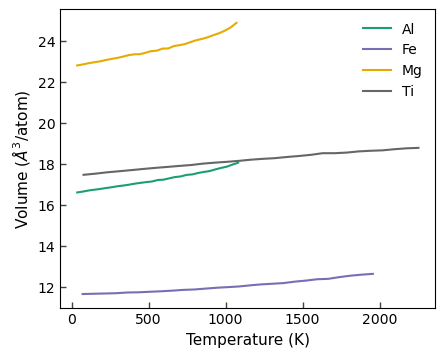

In [68]:
cmap = matplotlib.colormaps['Dark2']
colors = np.linspace(0, 1, len(res_dict))

mlt = Multiplot(width=350, ratio=0.8)
count = 0
for key, val in res_dict.items():
    mlt[0,0].plot(val['temp'], val['vol'], label=key, color=cmap(colors[count]))
    count += 1
mlt[0,0].legend(frameon=False)
mlt[0,0].set_xlabel('Temperature (K)', fontsize=11)
mlt[0,0].set_ylabel('Volume ($\AA^3$/atom)', fontsize=11)
plt.savefig('thermal_expansion.png', dpi=300, bbox_inches='tight')

In [69]:
for key, val in res_dict.items():
    print(key, val['alpha'])

Al 6.626092529857431e-05
Fe 2.095294054009922e-05
Mg 6.897171999379069e-05
Ti 4.2246331402419025e-05


<div class="admonition note" name="html-admonition" style="background:#e3f2fd; padding: 10px">
<font style="font-family:roboto;color:#455e6c;text-align:justify"> <a href="https://atomrdf.pyscal.org/en/latest/">atomRDF</a> | <a href="https://github.com/OCDO">Open Crystallographic Defects Ontologies</a> | <a href="https://nfdi-matwerk.de/">NFDI MatWerk</a> </font> </br>
</div>